# Library

In [1]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 33.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 57.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 86.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 29.4 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77717 sha256=638c884558aa9bb2e805935b6c53af570f46aa97158abba3f35bcc78b05f6124
  Stored in directory: /root/.cache/pip/wheels/e6/8e/67/e07554a720a493dc6b39b30488590ba92ed45448ad0134d253
Successfully built kaggle

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception

# Others
import shutil
import random

# Load dataset

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/ahmadhabibhasanzein/grape-leaves')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ahmadhabibhasanzein


Your Kaggle Key:

  ········


100%|██████████| 223M/223M [00:06<00:00, 38.6MB/s] 


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "grape-leaves/grape/train",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "grape-leaves/grape/valid",
    label_mode="categorical",
    class_names=['Grape Esca (Black_Measles)','Grape Leaf blight (Isariopsis_Leaf_Spot)','grape leaf Healthy','grape leaf black rot'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 7335 files belonging to 4 classes.
==========================Validation Data====================
Found 1825 files belonging to 4 classes.


In [6]:
# All images will be rescaled by 1./255.and augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.)

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("grape-leaves/grape/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("grape-leaves/grape/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 7335 images belonging to 4 classes.
Found 1825 images belonging to 4 classes.


# List Resource

In [7]:
# Check GPU
!nvidia-smi

Thu May 25 07:25:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   51C    P5    50W / 350W |  10509MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## Xception Model 1

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_Xception_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
Xception_model = tf.keras.models.Sequential([
    # Xception121 Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

83683744/83683744 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9382
Epoch 1: val_accuracy improved from -inf to 0.96822, saving model to Grape_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


367/367 [==============================] - 59s 108ms/step - loss: 0.1907 - accuracy: 0.9382 - val_loss: 0.0921 - val_accuracy: 0.9682 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9805
Epoch 2: val_accuracy did not improve from 0.96822
367/367 [==============================] - 26s 71ms/step - loss: 0.0718 - accuracy: 0.9805 - val_loss: 0.9470 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9812
Epoch 3: val_accuracy improved from 0.96822 to 0.98904, saving model to Grape_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


367/367 [==============================] - 38s 102ms/step - loss: 0.0889 - accuracy: 0.9812 - val_loss: 0.0422 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9925
Epoch 4: val_accuracy improved from 0.98904 to 0.99836, saving model to Grape_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


367/367 [==============================] - 37s 102ms/step - loss: 0.0346 - accuracy: 0.9925 - val_loss: 0.0057 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9787
Epoch 5: val_accuracy did not improve from 0.99836
367/367 [==============================] - 26s 72ms/step - loss: 0.0984 - accuracy: 0.9787 - val_loss: 0.1003 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9892
Epoch 6: val_accuracy did not improve from 0.99836
367/367 [==============================] - 27s 73ms/step - loss: 0.0451 - accuracy: 0.9892 - val_loss: 0.0265 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9888
Epoch 7: val_accuracy did not improve from 0.99836
367/367 [==============================] - 27s 72ms/step - loss: 0.0517 - accuracy: 0.9888 - val_loss: 0.3692 - val_a

INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model1_Based_Non_Augmented/assets


367/367 [==============================] - 38s 103ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0044 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 11/100
367/367 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9989
Epoch 11: val_accuracy did not improve from 0.99890
367/367 [==============================] - 26s 72ms/step - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.0049 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 12/100
367/367 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9992
Epoch 12: val_accuracy did not improve from 0.99890
367/367 [==============================] - 27s 72ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0142 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 13/100
367/367 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9995
Epoch 13: val_accuracy did not improve from 0.99890
367/367 [==============================] - 27s 73ms/step - loss: 0.0043 - accuracy: 0.9995 - val_lo

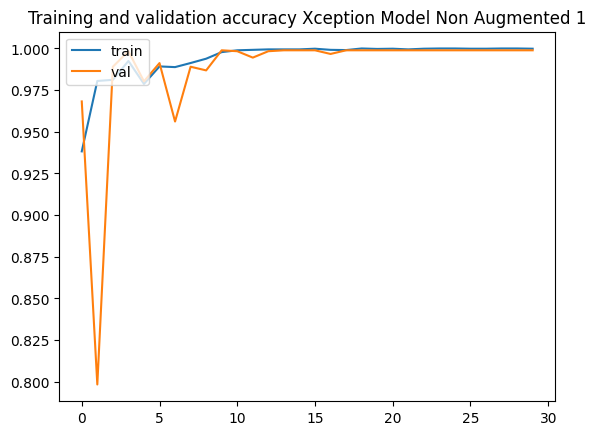

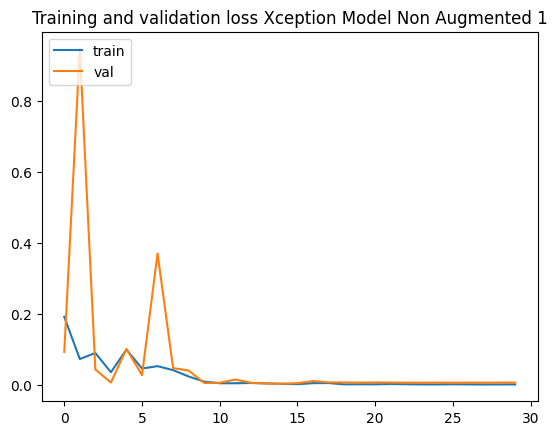

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model Non Augmented 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model Non Augmented 1')
plt.legend(['train', 'val'], loc='upper left')

## Xception Model 2

In [14]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Grape_Xception_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [15]:
# Define DIY Model
Xception_model_2 = tf.keras.models.Sequential([
    # Xception121 Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non-trainable params: 54,528
_____________________________________

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
367/367 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9542
Epoch 1: val_accuracy improved from -inf to 0.96603, saving model to Grape_Xception_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


367/367 [==============================] - 54s 106ms/step - loss: 0.1553 - accuracy: 0.9542 - val_loss: 0.1589 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 2/100
367/367 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9806
Epoch 2: val_accuracy did not improve from 0.96603
367/367 [==============================] - 26s 72ms/step - loss: 0.0593 - accuracy: 0.9806 - val_loss: 6.0911 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 3/100
367/367 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9858
Epoch 3: val_accuracy improved from 0.96603 to 0.99342, saving model to Grape_Xception_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


367/367 [==============================] - 38s 104ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.0222 - val_accuracy: 0.9934 - lr: 0.0010
Epoch 4/100
367/367 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9810
Epoch 4: val_accuracy did not improve from 0.99342
367/367 [==============================] - 27s 72ms/step - loss: 0.0830 - accuracy: 0.9810 - val_loss: 0.0973 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 5/100
367/367 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9898
Epoch 5: val_accuracy improved from 0.99342 to 0.99781, saving model to Grape_Xception_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


367/367 [==============================] - 38s 103ms/step - loss: 0.0509 - accuracy: 0.9898 - val_loss: 0.0087 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 6/100
367/367 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9922
Epoch 6: val_accuracy did not improve from 0.99781
367/367 [==============================] - 26s 72ms/step - loss: 0.0271 - accuracy: 0.9922 - val_loss: 0.0077 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 7/100
367/367 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9936
Epoch 7: val_accuracy did not improve from 0.99781
367/367 [==============================] - 27s 73ms/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 1.5399 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 8/100
367/367 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9936
Epoch 8: val_accuracy did not improve from 0.99781
367/367 [==============================] - 27s 73ms/step - loss: 0.0236 - accuracy: 0.9936 - val_loss: 0.2013 - val_a

INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


367/367 [==============================] - 38s 104ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 14/100
367/367 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9993
Epoch 14: val_accuracy did not improve from 0.99890
367/367 [==============================] - 27s 72ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9989 - lr: 1.0000e-04
Epoch 15/100
367/367 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 15: val_accuracy improved from 0.99890 to 1.00000, saving model to Grape_Xception_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


INFO:tensorflow:Assets written to: Grape_Xception_model2_Based_Non_Augmented/assets


367/367 [==============================] - 38s 103ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 9.3149e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 16/100
367/367 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995
Epoch 16: val_accuracy did not improve from 1.00000
367/367 [==============================] - 26s 72ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0054 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 17/100
367/367 [==============================] - ETA: 0s - loss: 7.6852e-04 - accuracy: 0.9999
Epoch 17: val_accuracy did not improve from 1.00000
367/367 [==============================] - 27s 73ms/step - loss: 7.6852e-04 - accuracy: 0.9999 - val_loss: 0.0034 - val_accuracy: 0.9984 - lr: 1.0000e-04
Epoch 18/100
367/367 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9997
Epoch 18: val_accuracy did not improve from 1.00000
367/367 [==============================] - 27s 73ms/step - loss: 0.0010 - accuracy: 0.9

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy Xception Model 2 Non Augmented')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss Xception Model 2 Non Augmented')
plt.legend(['train', 'val'], loc='upper left')